In [1]:
pip install tensorflow
pip install seaborn

connection successful!


In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time
import seaborn as sns
from snowflake.snowpark.session import Session
import configparser

import warnings
warnings.filterwarnings("ignore")

config = configparser.ConfigParser()
config.read("snowflake_connection.ini")

connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": f'{config["Snowflake"]["password"]}',
    "account": f'{config["Snowflake"]["account"]}',
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}

def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

Matplotlib created a temporary cache directory at /tmp/matplotlib-93o_48k2 because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


connection successful!


In [2]:
df = session.table("CPG_WAREHOUSE").to_pandas()

In [3]:
df.head(5)

,DATE,WARE_HOUSE_ID,WH_MANAGER_ID,LOCATION_TYPE,WH_CAPACITY_SIZE,ZONE,WH_REGIONAL_ZONE,REFILL_REQUESTS,TRANSPORT_ISSUE,NO_OF_COMPETITOR,...,ELECTRIC_SUPPLY,DIST_FROM_HUB,WORKERS_NUM,WH_EST_YEAR,STORAGE_ISSUE_REPORTED,TEMP_REG_MACH,APPROVED_WH_GOVT_CERTIFICATE,WH_BREAKDOWN,GOVT_CHECK,PRODUCT_WG_TON
0,2023-01-01,WH_100000,EID_50000,Urban,Small,West,Zone 6,3,1,2,...,1,91,29.0,NaN,13,0.0,A,5.0,15.0,17115.0
1,2023-01-01,WH_100001,EID_50001,Rural,Large,North,Zone 5,0,0,4,...,1,210,31.0,NaN,4,0.0,A,3.0,17.0,5074.0
2,2023-01-01,WH_100002,EID_50002,Rural,Mid,South,Zone 2,1,0,4,...,0,161,37.0,NaN,17,0.0,A,6.0,22.0,23137.0
3,2023-01-01,WH_100003,EID_50003,Rural,Mid,North,Zone 3,7,4,2,...,0,103,21.0,NaN,17,1.0,A+,3.0,27.0,22115.0
4,2023-01-01,WH_100004,EID_50004,Rural,Large,North,Zone 5,3,1,2,...,1,112,25.0,2009.0,18,0.0,C,6.0,24.0,24071.0


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350001 entries, 0 to 350000
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DATE                          350001 non-null  object 
 1   WARE_HOUSE_ID                 350001 non-null  object 
 2   WH_MANAGER_ID                 350001 non-null  object 
 3   LOCATION_TYPE                 350001 non-null  object 
 4   WH_CAPACITY_SIZE              350001 non-null  object 
 5   ZONE                          350001 non-null  object 
 6   WH_REGIONAL_ZONE              350001 non-null  object 
 7   REFILL_REQUESTS               350001 non-null  int8   
 8   TRANSPORT_ISSUE               350001 non-null  int8   
 9   NO_OF_COMPETITOR              350001 non-null  int8   
 10  NO_OF_RETAILERS               350001 non-null  int16  
 11  WAREHOUSE_OWNERSHIP           350001 non-null  object 
 12  NUMBER_OF_DISTRIBUTORS        350001 non-nul

In [8]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
REFILL_REQUESTS,350001.0,4.720761,3.648191,0.0,2.00,4.0,7.0,26.0
TRANSPORT_ISSUE,350001.0,2.426333,2.579299,0.0,0.00,2.0,4.0,22.0
NO_OF_COMPETITOR,350001.0,3.729101,2.997011,0.0,2.00,3.0,5.0,22.0
NO_OF_RETAILERS,350001.0,4985.876377,1285.713090,0.0,4141.00,4893.0,5724.0,12861.0
NUMBER_OF_DISTRIBUTORS,350001.0,61.922032,21.646701,8.0,46.00,62.0,77.0,146.0
FLOOD_IMPACTED,350001.0,0.098160,0.297531,0.0,0.00,0.0,0.0,1.0
FLOOD_PROOF,350001.0,0.054643,0.227282,0.0,0.00,0.0,0.0,1.0
ELECTRIC_SUPPLY,350001.0,0.656881,0.474752,0.0,0.00,1.0,1.0,1.0
DIST_FROM_HUB,350001.0,163.537113,62.717475,55.0,109.00,164.0,218.0,271.0
WORKERS_NUM,349011.0,37.665369,11.993045,0.0,30.00,37.0,45.0,124.0


In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

DATE                                 0
WARE_HOUSE_ID                        0
WH_MANAGER_ID                        0
LOCATION_TYPE                        0
WH_CAPACITY_SIZE                     0
ZONE                                 0
WH_REGIONAL_ZONE                     0
REFILL_REQUESTS                      0
TRANSPORT_ISSUE                      0
NO_OF_COMPETITOR                     0
NO_OF_RETAILERS                      0
WAREHOUSE_OWNERSHIP                  0
NUMBER_OF_DISTRIBUTORS               0
FLOOD_IMPACTED                       0
FLOOD_PROOF                          0
ELECTRIC_SUPPLY                      0
DIST_FROM_HUB                        0
WORKERS_NUM                        990
WH_EST_YEAR                     166335
STORAGE_ISSUE_REPORTED               0
TEMP_REG_MACH                        1
APPROVED_WH_GOVT_CERTIFICATE         1
WH_BREAKDOWN                         1
GOVT_CHECK                           1
PRODUCT_WG_TON                       1
dtype: int64

In [9]:
pip install tensorflow

     |████████████████████████████████| 479.6MB 1.9MB/s eta 0:00:011     |█████████████████████████▌      | 382.6MB 2.3MB/s eta 0:00:43
     |████████████████████████████████| 829kB 2.0MB/s eta 0:00:01
     |████████████████████████████████| 450kB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 143kB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 5.6MB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 296kB 1.3MB/s eta 0:00:01
     |████████████████████████████████| 61kB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 71kB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 1.7MB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 4.8MB 1.9MB/s eta 0:00:01
     |████████████████████████████████| 2.4MB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 24.5MB 2.2MB/s eta 0:00:01
     |████████████████████████████████| 92kB 2.9MB/s eta 0:00:01
     |███

     |████████████████████████████████| 194kB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 143kB 1.4MB/s eta 0:00:01
     |████████████████████████████████| 71kB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 163kB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 122kB 986kB/s eta 0:00:01
     |████████████████████████████████| 184kB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 153kB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 92kB 1.4MB/s eta 0:00:01
ERROR: sqlalchemy 2.0.28 has requirement typing-extensions>=4.6.0, but you'll have typing-extensions 4.5.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement importlib-metadata!=4.7.0,<7,>=3.7.0, but you'll have importlib-metadata 7.1.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement packaging<24, but you'll have packaging 24.0 which is incompatible.
ERROR: mlflow 2.6.0 has requirement pytz<2024, but you'll have pytz 2024.1 which is incompatible.
ERRO

Matplotlib created a temporary cache directory at /tmp/matplotlib-q6wo7mhm because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<Axes: >

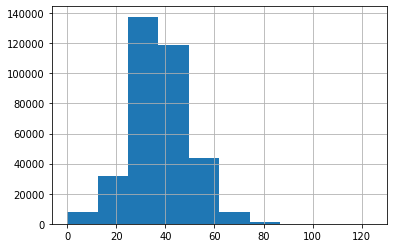

In [10]:
df['WORKERS_NUM'].hist()

In [12]:
df['WORKERS_NUM'] = df['WORKERS_NUM'].fillna(df['WORKERS_NUM'].mean())

APPROVED_WH_GOVT_CERTIFICATE
C     77014
B+    68837
B     67368
A     65394
A+    58674
NA    12712
0         1
Name: count, dtype: int64

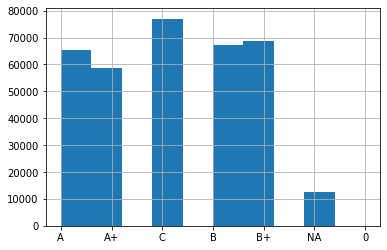

In [13]:
df['APPROVED_WH_GOVT_CERTIFICATE'].hist()
df['APPROVED_WH_GOVT_CERTIFICATE'].value_counts()

In [15]:
df['APPROVED_WH_GOVT_CERTIFICATE'].value_counts()

APPROVED_WH_GOVT_CERTIFICATE
C     77014
B+    68837
B     67368
A     65394
A+    58674
NA    12712
0         1
Name: count, dtype: int64

<Axes: >

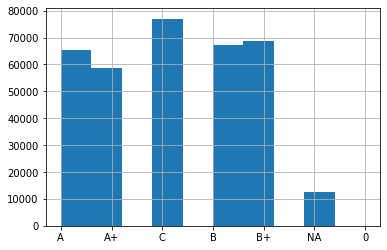

In [14]:
df['APPROVED_WH_GOVT_CERTIFICATE'].hist()

In [16]:
df['APPROVED_WH_GOVT_CERTIFICATE']=df['APPROVED_WH_GOVT_CERTIFICATE'].fillna(method='ffill')

In [17]:
sns.countplot(data=df,x='LOCATION_TYPE',hue='ZONE').set(title='Location Type by zone')

NameError: name 'sns' is not defined

In [18]:
pip install seaborn

     |████████████████████████████████| 296kB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 9.2MB 20.8MB/s eta 0:00:01
     |████████████████████████████████| 12.4MB 58.4MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 42.5MB/s eta 0:00:01
     |████████████████████████████████| 4.7MB 57.9MB/s eta 0:00:01
     |████████████████████████████████| 61kB 52.1MB/s eta 0:00:01
     |████████████████████████████████| 307kB 44.0MB/s eta 0:00:01
     |████████████████████████████████| 235kB 40.4MB/s eta 0:00:01
     |████████████████████████████████| 4.4MB 61.4MB/s eta 0:00:01
     |████████████████████████████████| 112kB 45.5MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 58.2MB/s eta 0:00:01
     |████████████████████████████████| 348kB 52.6MB/s eta 0:00:01
     |████████████████████████████████| 512kB 48.7MB/s eta 0:00:01
ERROR: refractio 2.1.5.4 has requirement pandas==2.0.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: mlflow 2.6.0 h

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
